In [1]:
import math
import numpy as np
from tqdm import tqdm
from icecream import ic
import cProfile 
import time
import warnings

In [2]:
# get ariety of np.add
np.maximum.nargs-1

2

In [3]:
#warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# Configuration
TRAIN_TEST_RATIO=0.6
PROBLEM_NUMBER=3

### Function definitions

In [5]:
# Normalize the training and testing data
def normalize_data(x, y, feature_range=(0, 1)):
    """
    Normalize input (x) and output (y) data using min-max normalization.

    Parameters:
        x: np.ndarray, input data (variables, samples).
        y: np.ndarray, output data (samples).
        feature_range: tuple (min, max), range for normalization.

    Returns:
        x_norm: Min-max normalized input data.
        y_norm: Min-max normalized output data.
        x_stats: Dict containing min and max for x.
        y_stats: Dict containing min and max for y.
    """
    x_min = np.min(x, axis=1, keepdims=True)
    x_max = np.max(x, axis=1, keepdims=True)
    x_norm = (x - x_min) / (x_max - x_min) * (feature_range[1] - feature_range[0]) + feature_range[0]

    y_min = np.min(y)
    y_max = np.max(y)
    y_norm = (y - y_min) / (y_max - y_min) * (feature_range[1] - feature_range[0]) + feature_range[0]

    x_stats = {"min": x_min, "max": x_max}
    y_stats = {"min": y_min, "max": y_max}

    return x_norm, y_norm, x_stats, y_stats

### Data Loading and Data Preprocessing

In [6]:
# Load problem data with context manager protocol
with np.load(f'data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train = x_1[:, :train_size]
y_train = y_1[:train_size]

x_test = x_1[:, train_size:]
y_test = y_1[train_size:]

# Normalize training and testing data
#FIXME: NORM
# x_train_norm, y_train_norm, x_stats, y_stats = normalize_data(x_train, y_train)
# x_test_norm, y_test_norm, _, _ = normalize_data(x_test, y_test)

# To view the npz file, run python -m npzviewer 
# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")
#FIXME: NORM
# print(f"Training data: x shape {x_train_norm.shape}, y shape {y_train_norm.shape}")
# print(f"Testing data: x shape {x_test_norm.shape}, y shape {y_test_norm.shape}")
print(f"Training data: x shape {x_train.shape}, y shape {y_train.shape}")
print(f"Testing data: x shape {x_test.shape}, y shape {y_test.shape}")



Problem number: 3, variables: 3, train size: 3000, test size: 2000
Training data: x shape (3, 3000), y shape (3000,)
Testing data: x shape (3, 2000), y shape (2000,)


### Numpy functions definition

In [7]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    np.arcsin,
    np.arccos,
    np.arctan,
    np.sinh,
    np.cosh,
    np.tanh,
    np.square,
    np.cbrt,
    np.reciprocal,
    np.rint

    # np.ceil,
    # np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    np.maximum,
    np.minimum,
    np.mod
]

### Symbolic Regression Class

In [8]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_per_island,island_num, max_generations, mutation_rate, elitism_size, grow_full_ratio,max_mutations,migration_rate,max_depth,spawn_depth,collapse_rate):
        self.population_per_island = population_per_island
        self.island_num = island_num
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio
        self.max_mutations = max_mutations
        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.migration_rate=migration_rate
        self.best_fitness_history = []
        #init np array  of size island_population
        self.max_depth = max_depth
        self.spawn_depth = spawn_depth
        self.population = [None] * island_num
        self.collapse_rate=collapse_rate
        #DEPTH BASED (decomment every DEPTH BASED line):
        # for j in range(island_num):
        #     self.population[j] = np.array([
        #         Tree("grow",max_depth=max_depth+j,spawn_depth=spawn_depth+j) if i < int(population_per_island * self.grow_full_ratio) else Tree("full",max_depth=max_depth+j,spawn_depth=spawn_depth+j) for i in range(population_per_island)
        #     ])
        for j in range(island_num):
            self.population[j] = np.array([
                Tree("grow",max_depth=max_depth,spawn_depth=spawn_depth) if i < int(population_per_island * self.grow_full_ratio) else Tree("full",max_depth=max_depth,spawn_depth=spawn_depth) for i in range(population_per_island)
            ])
         


    # Parents selection methods
    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10,island=0):
        """
        Individuals with lower fitness have an higher probability to be selected.
        Premature convergence if few individuals have significantly better fitness than others.
        """
        fitnesses = [tree.fitness for tree in self.population[island]]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population[island], size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
  

    def select_parents_rank_based(self, n_elems=2,island=0):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        """
        fitnesses = np.array([tree.fitness for tree in self.population[island]])
        ranks = np.argsort(fitnesses)
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population[island], n_elems, p=probabilities, replace=False)
    
    def select_parents_tournament(self,island=0):
        tournament_size = 5
        tournament = list(np.random.choice(self.population[island], tournament_size, replace=True))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    def select_parents(self, island):
        return self.select_parents_rank_based(island=island)

    # Mutation methods
    def mutate(self, tree):
        if np.random.rand() < 0.5:
            tree.mutate_subtree()
        else:
            mutations = np.random.randint(1, self.max_mutations+1)
            tree.mutate_single_node(num_mutations=mutations)
        
       


    # Offsprings generation via mutation and crossover
    def offspring_generation(self,island):
        new_population = np.array([])

        # Elitism   
        elite_individuals = self.population[island][:self.elitism_size]
        new_population = elite_individuals

        # Main loop
        while len(new_population) < self.population_per_island: #//2:
            parent1, parent2 = self.select_parents(island=island)

            # generate offsprings (one in mutation, two in crossover)
            offsprings = np.array([])

            if(np.random.rand() < self.mutation_rate):
                parent_clone = parent1.copy_tree()
                self.mutate(parent_clone)
                # parent_clone.root.collapse_branch()
                parent_clone.compute_fitness()
                # if(parent_clone not in new_population):
                offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1, offspring2 = parent1.crossover(parent2)
                if(offspring1 is not None or offspring2 is not None):
                    # offspring1.root.collapse_branch()
                    # offspring2.root.collapse_branch()
            
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()

                    offsprings = np.append(offsprings, [offspring1, offspring2])


            for offsp in offsprings:
                if(np.random.rand() < self.collapse_rate):
                    #clone the tree and collapse the branch
                    tree_clone = offsp.copy_tree()
                
                    Tree.collapse_branch(tree_clone.root,force_collapse=True)
                    tree_clone.compute_fitness()
                    #if the fitness is not nan or inf after collapsing
                    if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                            offsp = tree_clone

            new_population = np.concatenate((new_population, offsprings))
                
        return new_population
    
    # Genetic Algorithm: Evolutionary Process
    def evolve(self):
        best_tree_island = np.full(self.island_num, None, dtype=object)
        best_fitness_island = np.full(self.island_num, np.inf)
        global_best_fitness = np.inf
        global_best_tree = None
        take_over = np.full(self.island_num, False)
        # self.population_per_island.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        for i in range(self.island_num):
            self.population[i].sort()
      


        for generation in tqdm(range(self.max_generations)):
           
            for i in range(self.island_num):
                if take_over[i]:
                    # print(f"Takeover at {generation} gen on island {i} + {len(self.population[i])}")
                    # trasform the population in set and then back to list to remove duplicates
                    self.population[i] = np.unique(self.population[i])
                    # sort the population based on fitness
                    self.population[i].sort()
                    self.population[i] = self.population[i][:int(self.population_per_island*0.1)]
                    #DEPTH BASED (decomment every DEPTH BASED line):
                    # new_trees = np.array([Tree("grow",max_depth=self.max_depth+i,spawn_depth=self.spawn_depth+i) for _ in range(int(self.population_per_island*0.9))])
                    new_trees = np.array([Tree("grow",max_depth=self.max_depth,spawn_depth=self.spawn_depth) for _ in range(int(self.population_per_island*0.9))])
                    self.population[i]=np.concatenate((self.population[i],new_trees))
                    self.population[i].sort()
                
                #DEPTH BASED (decomment every DEPTH BASED line):
                # if np.random.rand()<self.migration_rate and i!=self.island_num-1:
                #     #pick a random island to migrate to that is greater than the current island
                #     island_to_migrate = np.random.randint(i+1,self.island_num)
                #     #add self.population[i][0] to self.population[island_to_migrate]
                #     self.population[island_to_migrate]=np.append(self.population[island_to_migrate],self.population[i][0])
                #     print(f"Migration at {generation} gen bewteen {i} and {island_to_migrate}")
               


                if np.random.rand()<self.migration_rate and self.island_num>1:
                    #pick a random island to migrate to that is greater than the current island
                    island_to_migrate = np.random.randint(0,self.island_num)
                    #select a random number from 0 to the population size of the current island
                    random_index = np.random.randint(0,len(self.population[i]))
                    #add self.population[i][random_index] to self.population[island_to_migrate]
                    self.population[island_to_migrate]=np.append(self.population[island_to_migrate],self.population[i][random_index])
                    #remove the tree from the current island
                    self.population[i]=np.delete(self.population[i],random_index)
                    


                    print(f"Migration at {generation} gen from {i} to {island_to_migrate}")


                new_population=self.offspring_generation(island=i)


                # for tree in new_population:
                #     tree.compute_fitness()
                    
                self.population[i]=np.concatenate((self.population[i],new_population))
                self.population[i].sort()
                
                generation_best_fitness_island = self.population[i][0].fitness

                if generation_best_fitness_island < best_fitness_island[i]:
                    best_fitness_island[i] = generation_best_fitness_island
                    best_tree_island[i] = self.population[i][0]
                    self.best_fitness_history.append(best_fitness_island[i])

                    if(best_fitness_island[i] < global_best_fitness):
                        global_best_fitness = best_fitness_island[i]
                        global_best_tree = best_tree_island[i]


                #trim the population to the best island_population
                
                self.population[i] = self.population[i][:self.population_per_island]
                # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")
                

                n_best = [elem for elem in self.population[i] if elem.fitness == self.population[i][0].fitness]
                take_over[i] = False
                if len(n_best) > 0.9 * self.population_per_island:
                        take_over[i] = True
                        # print(f"Takeover at {generation} gen")     
                if(generation%50==0):
                    print(f"Generation {generation + 1}, Island: {i}, Best Fitness: {best_fitness_island[i]}, Best Formula: {best_tree_island[i].to_np_formula()}")
                # if best_fitness <= 1e-33:
                #     break   

        return global_best_tree, global_best_fitness

### Problem Definition and Symbolic Regression Initialization

In [9]:
# --ISLAND SETTINGS--
ISLAND_POPULATION = 50
ISLAND_NUM = 5
MIGRATION_RATE = 0.001


# --TREE SETTINGS--
TREE_MAX_DEPTH = 7
TREE_SPAWN_DEPTH = 4 #the max depth at which the tree will be spawned, they can grow up to TREE_MAX_DEPTH

# --GENETIC ALGORITHM SETTINGS--
MAX_GENERATIONS = 1000
ELITISM_SIZE = 0
VAR_NUM = x_train.shape[0]
CONST_RANGE = 10 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]
MAX_MUTATIONS = 3  # Maximum number of mutations in a single mutation operation
MUTATION_RATE = 0.35
GROW_FULL_RATIO = 0.95
COLLAPSE_RATE = 0.3


#FIXME: NORM
# Tree.set_params(unary_ops, binary_ops, VAR_NUM, 10, TREE_DEPTH, x_train_norm, y_train_norm, x_test_norm, y_test_norm)

Tree.set_params(unary_ops, binary_ops, VAR_NUM, CONST_RANGE, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    ISLAND_POPULATION,
    ISLAND_NUM,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO,
    MAX_MUTATIONS,
    MIGRATION_RATE,
    TREE_MAX_DEPTH,
    TREE_SPAWN_DEPTH,
    COLLAPSE_RATE
    

    #(x_train, y_train)   # per lexicase
)
#print the trees


### Formula Revertion and Fitness Computation

In [10]:

def revert_formula(formula, x_stats, y_stats):
    """
    Revert a formula from normalized space to original space for min-max normalization.

    Parameters:
        formula: str, symbolic regression formula in normalized space.
        x_stats: dict, stats for input normalization (min, max).
        y_stats: dict, stats for output normalization (min, max).

    Returns:
        str, formula in the original space.
    """
    x_mins = x_stats["min"].flatten()
    x_maxs = x_stats["max"].flatten()
    y_min = y_stats["min"]
    y_max = y_stats["max"]

    # Wrap variables with normalization transformations
    for i, (x_min, x_max) in enumerate(zip(x_mins, x_maxs)):
        formula = formula.replace(
            f"x[{i}]",
            f"(x[{i}] * ({x_max} - {x_min}) + {x_min})"
        )

    # Apply the output transformation
    reverted_formula = f"(({formula}) * ({y_max} - {y_min})) + {y_min}"
    return reverted_formula

def compute_fitness_from_formula(formula, x_data, y_data):
    """
    Compute MSE fitness directly from a reverted formula.

    Parameters:
        formula: str, reverted symbolic regression formula.
        x_data: np.ndarray, input data in original scale (variables, samples).
        y_data: np.ndarray, true output data in original scale (samples).

    Returns:
        float, MSE fitness.
    """
    # Convert the formula to a lambda function
    eval_formula = eval(f"lambda x: {formula}", {"np": np})

    # Compute predictions
    y_pred = eval_formula(x_data)

    # Calculate MSE
    mse = np.mean(np.square(y_data - y_pred))
    return mse 

### Algorithm Execution and Results Computation

In [44]:
#UNCOMMENT TO PROFILE THE CODE (and comment the rest of the code)
# cProfile.run("regressor.evolve()",sort="tottime") #for profiling so we can see the time taken by each function
#the output will include the following columns:
#tottime: Total time spent in the function (excluding time spent in other functions it calls).
#cumtime: Cumulative time spent in the function (including time spent in sub-functions).

# Execute the algorithm
best_tree, best_fitness = regressor.evolve()    # FIX: high <= 0. There is a problem in mutate_subtree() after normalization?

print(f"Train Fitness: {best_fitness}")
# Calculate the fitness on original data
best_tree.compute_fitness(test="test")

# Revert the formula
final_formula = best_tree.to_np_formula()

#FIXME: NORM
# reverted_formula = revert_formula(final_formula, x_stats, y_stats)
# print(f"Reverted Formula:\n{reverted_formula}")

print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"All Fitness: {best_tree.fitness}")

#FIXME: NORM
# test_fitness_original=compute_fitness_from_formula(reverted_formula, x_test, y_test)
# print(f"Test Fitness Original: {test_fitness_original}")
# all_fitness_original=compute_fitness_from_formula(reverted_formula, x_train, y_train)
# print(f"all Fitness Original: {all_fitness_original}")

#Print the best tree
print(f"Best Fitness History: {regressor.best_fitness_history}, changed {len(regressor.best_fitness_history)} times")
print("Best Tree:")
best_tree.add_drawing()


  0%|          | 1/1000 [00:00<01:47,  9.31it/s]

Generation 1, Island: 0, Best Fitness: 2217.659896367984, Best Formula: np.multiply(np.minimum(np.minimum(np.remainder(x[1], np.maximum(-0.8854616564110973, -6.58251235725513)), np.multiply(x[0], -4.040675394717335)), np.remainder(np.subtract(x[2], -6.705519015200247), np.divide(x[2], -4.304910572799341))), np.minimum(np.maximum(np.remainder(-7.217951199898449, 6.793900190738029), np.power(7.399890871370321, -2.243533591555691)), np.minimum(x[1], np.exp(4.789601873674735))))
Generation 1, Island: 1, Best Fitness: 2382.385410930035, Best Formula: np.maximum(np.add(np.absolute(9.788478116484768), np.remainder(np.square(x[0]), np.multiply(x[0], x[0]))), np.multiply(np.multiply(np.subtract(x[1], x[0]), np.subtract(x[2], -3.686533953666789)), np.remainder(np.maximum(9.752960408324796, x[0]), np.arctan(-4.743166891034298))))
Generation 1, Island: 2, Best Fitness: 2708.5553219810017, Best Formula: np.remainder(np.reciprocal(x[2]), np.sqrt(np.remainder(x[1], np.power(6.680527188172732, x[0])))

  5%|▌         | 51/1000 [00:06<02:29,  6.33it/s]

Generation 51, Island: 0, Best Fitness: 455.4168002459328, Best Formula: np.multiply(np.minimum(np.minimum(np.multiply(x[1], np.subtract(0.8778148494655511, np.remainder(x[1], np.multiply(x[1], 3.4626196652052528)))), np.multiply(x[0], np.add(x[1], np.subtract(2.454447808266334, 4.242965484828424)))), np.remainder(np.divide(x[1], -7.52774615304525), np.divide(x[2], np.remainder(np.maximum(np.subtract(3.4626196652052528, 2.85968859994332), np.remainder(4.146371522522159, -5.477550809363216)), np.add(np.rint(8.905717992093813), -7.52774615304525))))), np.minimum(x[1], np.exp(np.multiply(x[1], 9.0085749803333))))
Generation 51, Island: 1, Best Fitness: 509.97343830304516, Best Formula: np.multiply(np.tanh(np.cbrt(np.add(x[1], np.remainder(np.multiply(x[1], 6.147109215849277), np.divide(np.divide(-5.1821274621536295, 6.546110235422244), np.multiply(x[2], -6.796867174843923)))))), np.minimum(np.multiply(x[1], np.subtract(2.360238593894671, 0.7425713121297086)), np.subtract(np.multiply(np.mu

  8%|▊         | 83/1000 [00:12<02:50,  5.37it/s]

### Best Tree Drawing

Collapsed formula: np.add(np.remainder(np.remainder(-0.49043682524673926, np.minimum(x[0], 5.611306313228393)), 8.80720911832935), np.add(np.multiply(np.add(x[1], x[1]), -7.47506198226596), np.multiply(np.multiply(x[2], -0.49043682524673926), 9.166040866908427)))
Best Tree after collapsing:


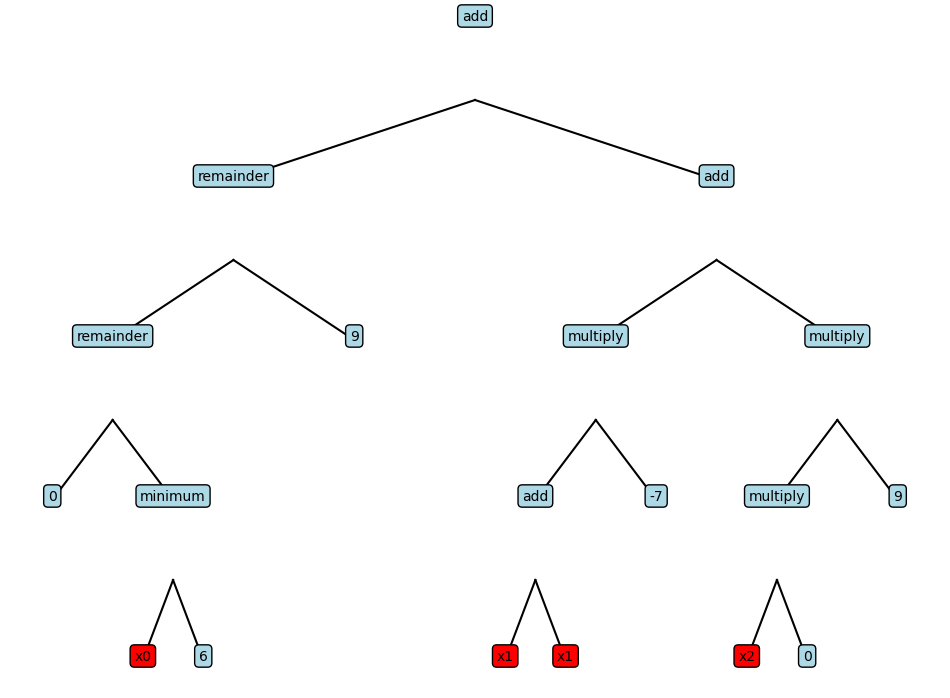

In [45]:

            
tree_clone = best_tree.copy_tree()  
Tree.collapse_branch(tree_clone.root,0,force_collapse=True)
tree_clone.compute_fitness()           
if(tree_clone.fitness is not None or tree_clone.fitness is not np.inf and tree_clone.fitness is not np.nan):
                    best_tree = tree_clone


print(f"Collapsed formula: {best_tree.to_np_formula()}")
print("Best Tree after collapsing:")
best_tree.add_drawing()


In [46]:
tree = Tree("grow",max_depth=TREE_MAX_DEPTH,spawn_depth=TREE_SPAWN_DEPTH)

In [47]:
formula = tree.to_np_formula()
tree2 = Tree.create_tree_from_np_formula(formula)
# tree2.compute_fitness()
# tree.compute_fitness()
assert tree.to_np_formula() == tree2.to_np_formula()
assert tree.fitness == tree2.fitness

### Some tests

In [48]:

# def test_formula(x):
#     pass



# x_tot=np.concatenate((x_train,x_test),axis=1)
# y_tot=np.concatenate((y_train,y_test))
# squared_errors = 0
# for i in range(1):
#     y_pred = test_formula(x_tot[:, i])
                 
#     squared_errors += np.square(y_tot[i] - y_pred) 

# print( squared_errors / x_tot.shape[1])
   

# def testing(tree):
#    tree.compute_fitness()
#    tree.compute_fitness2()

# cProfile.run("testing(best_tree)",sort="tottime") #for profiling so we can see the time taken by each function


# best_tree.compute_fitness()
# print(best_tree.fitness)
# best_tree.compute_fitness2()
# print(best_tree.fitness)
